In [9]:
from keras_facenet import FaceNet

from mtcnn.mtcnn import MTCNN

from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image,ImageDraw
from PIL import ImageFilter
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
import glob

In [10]:
embedder = FaceNet()
detector = MTCNN()

In [11]:
def visual_multi(path_file):

  nplots = sorted(os.listdir(path_file))
  fig = plt.figure(figsize=(8,4))
  for j in range(len(nplots)):
    # print(path_file+nplots[j])
    img = cv2.resize(cv2.imread(path_file+nplots[j]),(224,224))
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4,10,j+1)
    plt.imshow(image_rgb)
    plt.title(j)
    plt.xticks([]);plt.yticks([])
  plt.show()

In [195]:
def extraction_keras_all(file_name): # take embeddings, and position
  file_names = glob.glob(file_name)
  embedding_faces = []
  data_position = {}
  crop_face = {}
  images = []
  for i,image in enumerate(file_names):
    image = Image.open(image).convert('RGB')
    im_arr = np.array(image)
    images.append(im_arr)
    faces = detector.detect_faces(im_arr,)
    datafaces = []
    position_crop =  []
    for j in faces:
      x1,y1,width,height = j['box']
      x2,y2 = (x1+width),(y1+height)
      datafaces.append([x1,y1,x2,y2])
      position_crop.append([y1,y2,x1,x2])
    data_position[i] = datafaces
    crop_face[i] = position_crop
    datafaces = []
    position_crop = []
    
  '''for delete file in image_lock'''
  if os.listdir(r'C:\Users\Raum\Desktop\jec\code\image_lock\\') !=[]:
    for i in os.listdir(r'C:\Users\Raum\Desktop\jec\code\image_lock\\'):
      file_image = os.path.join(r'C:\Users\Raum\Desktop\jec\code\image_lock\\',i)
      os.remove(file_image)

  index_image = 1
  for i,img in enumerate(images):
      for j in crop_face[i]:
        face = img[j[0]:j[1],j[2]:j[3]]
        image_face = Image.fromarray(face)
        image_face = image_face.resize((224,224))
        faces_crops = np.array(image_face).reshape(-1,224,224,3)
        embedding_faces.append(embedder.embeddings(faces_crops))
        index_image+=1
        path = r'C:\Users\Raum\Desktop\jec\code\image_lock\{}_lock_face_{}.jpg'.format(i,index_image) # path for collect images
        image_face.save(path)
      
  return embedding_faces,data_position

In [196]:
embedding_faces,position=extraction_keras_all(r"C:\Users\Raum\Desktop\รูปเที่ยว\*") # lock by self-image

In [101]:
f = r'C:\Users\Raum\Desktop\jec\code\dataface\avenger.jpg'
m = r'C:\Users\Raum\Desktop\jec\code\dataface\dogmeme.png'
em,po = extraction_keras_all(r'C:\Users\Raum\Desktop\jec\code\dataface\avenger.jpg')
# embedding_faces,position=extraction_keras_all(glob.glob(r"C:\Users\Raum\Desktop\รูปเที่ยว")) # lock by self-image

TypeError: cannot unpack non-iterable int object

In [90]:
em,poa = extraction_keras_all(glob.glob(r"C:\Users\Raum\Desktop\jec\code\dataface\avenger.jpg"))

{0: [[700, 311, 769, 403],
  [492, 408, 573, 526],
  [281, 370, 351, 477],
  [231, 244, 280, 313],
  [595, 106, 683, 227],
  [334, 0, 492, 204],
  [198, 380, 238, 440],
  [448, 257, 508, 339],
  [371, 505, 412, 560]],
 1: [[386, 91, 646, 437]],
 2: [[147, 136, 179, 179],
  [24, 103, 61, 143],
  [225, 84, 263, 125],
  [200, 99, 225, 134],
  [97, 98, 125, 134],
  [156, 51, 181, 83],
  [212, 5, 223, 18],
  [66, 104, 93, 141],
  [83, 32, 97, 48],
  [249, 25, 261, 40],
  [51, 71, 70, 91],
  [44, 160, 77, 202],
  [3, 47, 18, 67],
  [189, 49, 208, 68]],
 3: [[909, 327, 1076, 533]],
 4: [[126, 22, 189, 107], [210, 104, 252, 159]],
 5: [[1250, 398, 1320, 488],
  [1782, 480, 1843, 547],
  [1503, 364, 1579, 467],
  [714, 320, 792, 423],
  [350, 388, 421, 484],
  [568, 375, 631, 462],
  [1008, 279, 1088, 393],
  [1591, 442, 1658, 511],
  [827, 399, 882, 470]],
 6: [[804, 228, 1100, 620]],
 7: [[558, 170, 885, 574]],
 8: [[343, 122, 541, 373]],
 9: [[904, 177, 1105, 457]],
 10: [[567, 169, 652, 280

In [ ]:
f = r'C:\Users\Raum\Desktop\jec\code\dataface\avenger.jpg'
m = r'C:\Users\Raum\Desktop\jec\code\dataface\dogmeme.png'
embedding_faces,position=extraction_keras_all(f) # lock by self-image

In [6]:
def plot_result(file_image,embedding_faces,position,lock_face=None,file_filter=None):
  log_cosine_similarity = []
  image = Image.open(file_image).convert('RGB')
  if file_filter is None:
      draw = ImageDraw.Draw(image)
  else:
    fitter_image = Image.open(file_filter).convert('RGBA')


  Detection_check = np.zeros((len(position)))
  if lock_face : 
    '''if want to blur >=2 in images'''
    for j in range(len(lock_face)):
      for i in range(len(position)):
            similar = cosine_similarity(embedding_faces[lock_face[j]], embedding_faces[i])
            log_cosine_similarity.append(similar)
            if similar>0.9 and Detection_check[i] ==0 :
              Detection_check[i] = 1
              break


  for i in range(len(position)):
      if Detection_check[i] == 1:
        # draw.rectangle([(position[i][0],position[i][1]),(position[i][2],position[i][3])],outline=(25,255,0),width=5)
        pass
      else :
        x = int((position[i][2]-position[i][0]))
        y = int((position[i][3]-position[i][1]))
        # print(x,y)
        if file_filter is None:
          censor_region = (position[i][0],position[i][1], position[i][2],position[i][3])  # Format: (left, top, right, bottom)
          censored_area = image.crop(censor_region)
          
          censored_width, censored_height = censored_area.size
          censored_area = censored_area.resize(
              (6, 6),
              Image.NEAREST
          ).resize(
              (censored_width, censored_height),
              Image.NEAREST
          )
          image.paste(censored_area, censor_region)

        else:
          fitter_face = fitter_image.resize((x,y))
          image.paste(fitter_face,(position[i][0], position[i][1]),fitter_face) # gan:X, gan:Y
      
        
  return image,log_cosine_similarity

def plot_box(file_image,position):
  image = Image.open(file_image).convert('RGB')
  draw = ImageDraw.Draw(image)
  for i in range(len(position)):
    draw.rectangle([(position[i][0],position[i][1]),(position[i][2],position[i][3])],outline=(255,0,0),width=5)
  image.show()

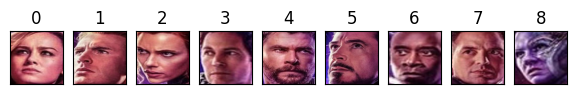

In [7]:
f = r'C:\Users\Raum\Desktop\jec\code\dataface\avenger.jpg'
m = r'C:\Users\Raum\Desktop\jec\code\dataface\dogmeme.png'
embedding_faces,position=extraction_keras_all(f) # lock by self-image

img,va = plot_result(f,embedding_faces,position,lock_face=[0,8,4],file_filter=m)
# img,va = plot_result(f,[0,8,4],embedding_faces,position,m)

In [8]:
img.show()

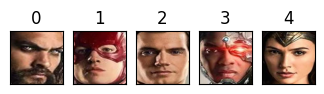

In [9]:
f = r'C:\Users\Raum\Desktop\jec\code\dataface\superman4.jpg'
m = r'C:\Users\Raum\Desktop\jec\code\dataface\dogmeme.png'
embedding_faces,position=extraction_keras_all(f) # lock by self-image

In [10]:
img,_ = plot_result(f,embedding_faces,position,lock_face=[0])
img.show()

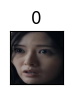

In [12]:
f = r"C:\Users\Raum\Desktop\array_of_frame\allframe\frame_1289.jpg"
m = r'C:\Users\Raum\Desktop\jec\code\dataface\dogmeme.png'
embedding_faces,position=extraction_keras_all(f) # lock by self-image
img,_ = plot_result(f,embedding_faces,position,file_filter=None)
img.show()

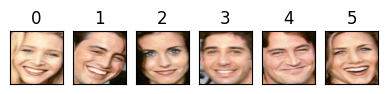

In [25]:
f = r"C:\Users\Raum\Downloads\archive (2)\Friends\Test\all (9).jpg"
embedding_faces,position=extraction_keras_all(f) # lock by self-image
img,_ = plot_result(f,embedding_faces,position,file_filter=None,lock_face=[4])
img.show()
img.save('new.jpg')

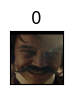

In [12]:
f = r"C:\Users\Raum\Desktop\testversion2\test_image\frame_676.jpg"
l = r'C:\Users\Raum\Desktop\jec\code\dataface\kkkk.png'
embedding_faces,position=extraction_keras_all(f) # lock by self-image
# img,_ = plot_result(f,embedding_faces,position,lock_face=[5],file_filter=l)
# img.show()


In [19]:
img.save('too.jpg')